# Rainfall time-series dataset released by WFP 

The data regarding the rainfall are provided to the wfp: https://dataviz.vam.wfp.org/seasonal_explorer/rainfall_vegetation/visualizations#

In [1]:
from plotly_dataframe import plot
from plot_map import draw_admin
import pandas as pd
import ntpath
import glob

In [2]:
# Define the path where the results arising from this analysis will be saved.
path_to_save_data = "./time-series/"

# Dekad granularity (month) data - YEM

The files downloaded are that selected with "all" from the site.

In [3]:
# Read the data released by wfp regarding the rainfall in the adminstratas of the selected countries.
path = "./wfp_data/Rainfall/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_subfolders = glob.glob(path + country + "/*")
    for subfolder in all_subfolders:
        adminstrata = ntpath.basename(subfolder).split(".")[0]
        # All the files of the years.
        all_files = glob.glob(subfolder + "/*.csv")
        for filename in all_files:
            df = pd.read_csv(filename)
            df["AdminStrata"] = adminstrata
            df["Country"] = country
            dfs.append(df)

In [4]:
print("The data released by wfp:")
df = pd.concat(dfs, axis = 0, ignore_index = True)
df.head()

The data released by wfp:


,Year,Month,Dekad,Rainfall (mm),Average (mm),AdminStrata,Country
0,2014,1,1,0.891,0.419,Abyan,Yemen
1,2014,1,2,0.505,0.118,Abyan,Yemen
2,2014,1,3,0.887,0.477,Abyan,Yemen
3,2014,2,1,1.220,1.011,Abyan,Yemen
4,2014,2,2,1.898,1.168,Abyan,Yemen


### Brief items description

- *Year*: reference year of the data collection.
- *Month*: reference month of the data collection.
- *Dekad*: reference month dekad of the data collection: these correspond to the calendar dates 1-10, 11-20, and 21-end of each month.
- *Rainfall (mm)*: rainfall amount in the reference period.
- *Average (mm)*: long-term rainfall average for the same period starting from 1994 to 2013.
- *AdminStrata*: the adminstrata information of the reference country.
- *Country*: the country information.

In [5]:
# Delete the duplicate rows of the dataframe (some date have duplicate information due to loading data from different files).
df.drop_duplicates(inplace = True)

### Country item

In [6]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Yemen


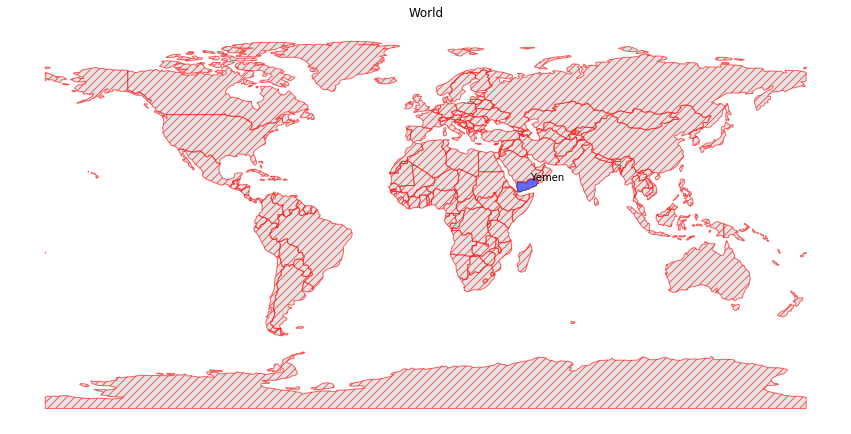

In [7]:
draw_admin("World", df.Country.unique(), figsize = (15, 9), annotation = True, annotation_selected = True)

### AdminStrata item

In [8]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen**: the administrative division of Yemen is divided into two main divisions (governorates and districts). There are 22 governorates, including the capital Sana'a (Amanat Al Asimah) and Socotra Archipelago. The rainfall dataframe has the values of all the governorates.

In [9]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", 'Al Hudaydah',
       'Al Jawf', 'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran',
       'Dhamar', 'Hadramaut', 'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah',
       "Sa'ada", "Sana'a", 'Shabwah', 'Socotra', 'Taizz'], dtype=object)

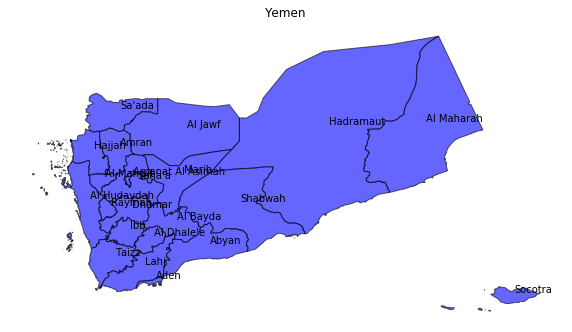

In [10]:
draw_admin("Yemen", AdminStratas["Yemen"], figsize = (10, 7), annotation = True)

In [11]:
# Convert the dekad to proper pandas datetime format.
# These correspond to the calendar dates 1-10, 11-20, and 21-end of each month.
def dekad_to_day(row):
    date = pd.to_datetime(str(row["Year"]) + "-" + str(row["Month"]) + "-01")
    end_month = date.days_in_month
    dekad = row.Dekad   
    if dekad == 1:
        return 10
    if dekad == 2:
        return 20
    if dekad == 3:
        return end_month
    
df["Day"] = df.apply(dekad_to_day, axis = 1)
df.drop(columns = "Dekad", inplace = True)
data = pd.to_datetime(df[["Year", "Month", "Day"]])
df.insert(1, "Datetime", data)
df.drop(["Year", "Month", "Day"], axis = 1, inplace = True)
df.sort_values("Datetime", ascending = True, inplace = True) 
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,Rainfall (mm),Average (mm)
0,Yemen,Abyan,2014-01-10,0.891,0.419
1,Yemen,Abyan,2014-01-11,NaN,NaN
2,Yemen,Abyan,2014-01-12,NaN,NaN
3,Yemen,Abyan,2014-01-13,NaN,NaN
4,Yemen,Abyan,2014-01-14,NaN,NaN


In [12]:
# Create a dataframe with multi-column in order to have a summary dataframe of the time-series.
df.drop(labels = ["Average (mm)"], axis = 1, inplace = True)
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"])
df.columns = df.columns.droplevel(0)
df.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple([x[0], x[1], "Rainfall (mm)"]), df.columns)))
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq

In [13]:
# Select data between a temporal range.
df = df.loc[(df.index >= "2017-01-10") & (df.index <= "2020-04-20")]
df.head()

Country             Yemen                                            \
AdminStrata         Abyan          Aden      Al Bayda    Al Dhale'e   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10          0.752           0.0         0.997         0.255   
2017-01-11            NaN           NaN           NaN           NaN   
2017-01-12            NaN           NaN           NaN           NaN   
2017-01-13            NaN           NaN           NaN           NaN   
2017-01-14            NaN           NaN           NaN           NaN   

Country                                                              \
AdminStrata   Al Hudaydah       Al Jawf    Al Maharah     Al Mahwit   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10          0.796         1.522         4.446         0.821   
2017-01-11            NaN           NaN           NaN           NaN   
2017-01-12            NaN           NaN           NaN           NaN   
2017-01-13            NaN           NaN           NaN           NaN   
2017-01-14            NaN           NaN           NaN           NaN   

Country                                     ...                              \
AdminStrata Amanat Al Asimah         Amran  ...        Hajjah           Ibb   
Indicator      Rainfall (mm) Rainfall (mm)  ... Rainfall (mm) Rainfall (mm)   
Datetime                                    ...                               
2017-01-10             0.143         1.064  ...         0.982         0.827   
2017-01-11               NaN           NaN  ...           NaN           NaN   
2017-01-12               NaN           NaN  ...           NaN           NaN   
2017-01-13               NaN           NaN  ...           NaN           NaN   
2017-01-14               NaN           NaN  ...           NaN           NaN   

Country                                                              \
AdminStrata          Lahj         Marib        Raymah        Sa'ada   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10          0.283         1.988          0.27         0.806   
2017-01-11            NaN           NaN           NaN           NaN   
2017-01-12            NaN           NaN           NaN           NaN   
2017-01-13            NaN           NaN           NaN           NaN   
2017-01-14            NaN           NaN           NaN           NaN   

Country                                                              
AdminStrata        Sana'a       Shabwah       Socotra         Taizz  
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)  
Datetime                                                             
2017-01-10          0.945         1.685         1.278         0.595  
2017-01-11            NaN           NaN           NaN           NaN  
2017-01-12            NaN           NaN           NaN           NaN  
2017-01-13            NaN           NaN           NaN           NaN  
2017-01-14            NaN           NaN           NaN           NaN  

[5 rows x 22 columns]

In [14]:
# Now check if it is necessary interolate the nan values of the datetime dekadly.
df = df.loc[(df.index.day == 10) | (df.index.day == 20) | (df.index.is_month_end)]
# Keep dataframe from first to end valid index based on the measured rainfall.
first_idx = df.first_valid_index()
last_idx = df.last_valid_index()
df = df.loc[first_idx:last_idx]
# Check if the dataframe contains NaN values in correspondence of the dekades.
print("Check if the dataframe contains NaN values:")
df.isnull().sum()

Check if the dataframe contains NaN values:


Country  AdminStrata       Indicator    
Yemen    Abyan             Rainfall (mm)    0
         Aden              Rainfall (mm)    0
         Al Bayda          Rainfall (mm)    0
         Al Dhale'e        Rainfall (mm)    0
         Al Hudaydah       Rainfall (mm)    0
         Al Jawf           Rainfall (mm)    0
         Al Maharah        Rainfall (mm)    0
         Al Mahwit         Rainfall (mm)    0
         Amanat Al Asimah  Rainfall (mm)    0
         Amran             Rainfall (mm)    0
         Dhamar            Rainfall (mm)    0
         Hadramaut         Rainfall (mm)    0
         Hajjah            Rainfall (mm)    0
         Ibb               Rainfall (mm)    0
         Lahj              Rainfall (mm)    0
         Marib             Rainfall (mm)    0
         Raymah            Rainfall (mm)    0
         Sa'ada            Rainfall (mm)    0
         Sana'a            Rainfall (mm)    0
         Shabwah           Rainfall (mm)    0
         Socotra           Rainfall (mm

In [15]:
# Resample data to daily level (as before).
df = df.resample("D").mean()
df.head()

Country             Yemen                                            \
AdminStrata         Abyan          Aden      Al Bayda    Al Dhale'e   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10          0.752           0.0         0.997         0.255   
2017-01-11            NaN           NaN           NaN           NaN   
2017-01-12            NaN           NaN           NaN           NaN   
2017-01-13            NaN           NaN           NaN           NaN   
2017-01-14            NaN           NaN           NaN           NaN   

Country                                                              \
AdminStrata   Al Hudaydah       Al Jawf    Al Maharah     Al Mahwit   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10          0.796         1.522         4.446         0.821   
2017-01-11            NaN           NaN           NaN           NaN   
2017-01-12            NaN           NaN           NaN           NaN   
2017-01-13            NaN           NaN           NaN           NaN   
2017-01-14            NaN           NaN           NaN           NaN   

Country                                     ...                              \
AdminStrata Amanat Al Asimah         Amran  ...        Hajjah           Ibb   
Indicator      Rainfall (mm) Rainfall (mm)  ... Rainfall (mm) Rainfall (mm)   
Datetime                                    ...                               
2017-01-10             0.143         1.064  ...         0.982         0.827   
2017-01-11               NaN           NaN  ...           NaN           NaN   
2017-01-12               NaN           NaN  ...           NaN           NaN   
2017-01-13               NaN           NaN  ...           NaN           NaN   
2017-01-14               NaN           NaN  ...           NaN           NaN   

Country                                                              \
AdminStrata          Lahj         Marib        Raymah        Sa'ada   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10          0.283         1.988          0.27         0.806   
2017-01-11            NaN           NaN           NaN           NaN   
2017-01-12            NaN           NaN           NaN           NaN   
2017-01-13            NaN           NaN           NaN           NaN   
2017-01-14            NaN           NaN           NaN           NaN   

Country                                                              
AdminStrata        Sana'a       Shabwah       Socotra         Taizz  
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)  
Datetime                                                             
2017-01-10          0.945         1.685         1.278         0.595  
2017-01-11            NaN           NaN           NaN           NaN  
2017-01-12            NaN           NaN           NaN           NaN  
2017-01-13            NaN           NaN           NaN           NaN  
2017-01-14            NaN           NaN           NaN           NaN  

[5 rows x 22 columns]

## Interpolation of the time-series at day granularity

I get the dataframe with time step of the day filling nan values (because I have information only for the dekades of the month) with previous value dekad. More precisely, being the values of the dekaed the tototal amount of rainfall happened in that interval I divide for the days of the range of the dekad.

In [16]:
# I get the dataframe with time step of the day filling nan values with previous value dekad.
df_fit = df.fillna(method = "bfill")
freq = "D"
df_fit.index.freq = freq
# Furthermore, being the values of the dekaed the tot rainfall happened in that interval I divide for the days of the range of the dekad.
def dekad_day_norm(row):
    if row.name.day >= 1 or row.name.day <= 10:
        return row/10
    if row.name.day >= 11 or row.name.day <= 20:
        return row/10
    if row.name.day >= 21:
        return row/row.name.days_in_month - 20

df_fit = df_fit.apply(dekad_day_norm, axis = 1)
df_fit.head()

Country             Yemen                                            \
AdminStrata         Abyan          Aden      Al Bayda    Al Dhale'e   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10         0.0752           0.0        0.0997        0.0255   
2017-01-11         0.0406           0.0        0.0673        0.0015   
2017-01-12         0.0406           0.0        0.0673        0.0015   
2017-01-13         0.0406           0.0        0.0673        0.0015   
2017-01-14         0.0406           0.0        0.0673        0.0015   

Country                                                              \
AdminStrata   Al Hudaydah       Al Jawf    Al Maharah     Al Mahwit   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10         0.0796        0.1522        0.4446        0.0821   
2017-01-11         0.0651        0.1490        0.4682        0.0667   
2017-01-12         0.0651        0.1490        0.4682        0.0667   
2017-01-13         0.0651        0.1490        0.4682        0.0667   
2017-01-14         0.0651        0.1490        0.4682        0.0667   

Country                                     ...                              \
AdminStrata Amanat Al Asimah         Amran  ...        Hajjah           Ibb   
Indicator      Rainfall (mm) Rainfall (mm)  ... Rainfall (mm) Rainfall (mm)   
Datetime                                    ...                               
2017-01-10            0.0143        0.1064  ...        0.0982        0.0827   
2017-01-11            0.0000        0.0887  ...        0.0964        0.0559   
2017-01-12            0.0000        0.0887  ...        0.0964        0.0559   
2017-01-13            0.0000        0.0887  ...        0.0964        0.0559   
2017-01-14            0.0000        0.0887  ...        0.0964        0.0559   

Country                                                              \
AdminStrata          Lahj         Marib        Raymah        Sa'ada   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-01-10         0.0283        0.1988        0.0270        0.0806   
2017-01-11         0.0157        0.1903        0.0032        0.0751   
2017-01-12         0.0157        0.1903        0.0032        0.0751   
2017-01-13         0.0157        0.1903        0.0032        0.0751   
2017-01-14         0.0157        0.1903        0.0032        0.0751   

Country                                                              
AdminStrata        Sana'a       Shabwah       Socotra         Taizz  
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)  
Datetime                                                             
2017-01-10         0.0945        0.1685        0.1278        0.0595  
2017-01-11         0.0649        0.1461        0.0008        0.0509  
2017-01-12         0.0649        0.1461        0.0008        0.0509  
2017-01-13         0.0649        0.1461        0.0008        0.0509  
2017-01-14         0.0649        0.1461        0.0008        0.0509  

[5 rows x 22 columns]

Now, I adjust the current data according to the reference period of the data collection of the fcs indicator. The fcs survey uses a sliding window of 30 days past to determine the current value. 

In [17]:
SvyWindow = 30

In [18]:
df_fit = df_fit.rolling(SvyWindow + 1).sum().dropna()
df_fit.head()

Country             Yemen                                            \
AdminStrata         Abyan          Aden      Al Bayda    Al Dhale'e   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-02-09         2.7646        0.9840        3.5742        2.7302   
2017-02-10         2.8369        1.0882        3.6627        2.8938   
2017-02-11         2.9905        1.3299        3.8294        3.2595   
2017-02-12         3.1441        1.5716        3.9961        3.6252   
2017-02-13         3.2977        1.8133        4.1628        3.9909   

Country                                                              \
AdminStrata   Al Hudaydah       Al Jawf    Al Maharah     Al Mahwit   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-02-09         4.8872        4.5546       11.5012        4.2037   
2017-02-10         5.1262        4.5291       11.2463        4.3754   
2017-02-11         6.2380        4.7166       10.9113        5.1792   
2017-02-12         7.3498        4.9041       10.5763        5.9830   
2017-02-13         8.4616        5.0916       10.2413        6.7868   

Country                                     ...                              \
AdminStrata Amanat Al Asimah         Amran  ...        Hajjah           Ibb   
Indicator      Rainfall (mm) Rainfall (mm)  ... Rainfall (mm) Rainfall (mm)   
Datetime                                    ...                               
2017-02-09            1.2431        3.8218  ...        5.1653        3.7041   
2017-02-10            1.3217        3.8808  ...        5.3921        3.8326   
2017-02-11            1.5931        4.2575  ...        6.3007        4.2845   
2017-02-12            1.8645        4.6342  ...        7.2093        4.7364   
2017-02-13            2.1359        5.0109  ...        8.1179        5.1883   

Country                                                              \
AdminStrata          Lahj         Marib        Raymah        Sa'ada   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-02-09         2.8018        5.7471        3.3051        4.8321   
2017-02-10         2.9871        5.7018        3.5146        5.0662   
2017-02-11         3.3785        5.7621        4.3749        5.7044   
2017-02-12         3.7699        5.8224        5.2352        6.3426   
2017-02-13         4.1613        5.8827        6.0955        6.9808   

Country                                                              
AdminStrata        Sana'a       Shabwah       Socotra         Taizz  
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)  
Datetime                                                             
2017-02-09         3.2782        4.6800        0.1862        3.9888  
2017-02-10         3.3315        4.6258        0.0640        4.1689  
2017-02-11         3.7504        4.6426        0.0775        4.8144  
2017-02-12         4.1693        4.6594        0.0910        5.4599  
2017-02-13         4.5882        4.6762        0.1045        6.1054  

[5 rows x 22 columns]

In [19]:
# According to the FCS and rCSI survey, I consider the provinces of Hadramaut and Socotra as one. I take the Hadramaut province as reference.
def Hadramaut_Socotra(serie):
    adminstrata = serie.name[1]
    if adminstrata == "Hadramaut":
        socotra = df_fit[("Yemen", "Socotra", "Rainfall (mm)")]
        return serie + socotra
    else:
        return serie

df_fit = df_fit.apply(Hadramaut_Socotra)
# Delete Socotra adminstrata.
df_fit.drop(columns = ("Yemen", "Socotra", "Rainfall (mm)"), inplace = True)
df_fit.head()

Country             Yemen                                            \
AdminStrata         Abyan          Aden      Al Bayda    Al Dhale'e   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-02-09         2.7646        0.9840        3.5742        2.7302   
2017-02-10         2.8369        1.0882        3.6627        2.8938   
2017-02-11         2.9905        1.3299        3.8294        3.2595   
2017-02-12         3.1441        1.5716        3.9961        3.6252   
2017-02-13         3.2977        1.8133        4.1628        3.9909   

Country                                                              \
AdminStrata   Al Hudaydah       Al Jawf    Al Maharah     Al Mahwit   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-02-09         4.8872        4.5546       11.5012        4.2037   
2017-02-10         5.1262        4.5291       11.2463        4.3754   
2017-02-11         6.2380        4.7166       10.9113        5.1792   
2017-02-12         7.3498        4.9041       10.5763        5.9830   
2017-02-13         8.4616        5.0916       10.2413        6.7868   

Country                                     ...                              \
AdminStrata Amanat Al Asimah         Amran  ...     Hadramaut        Hajjah   
Indicator      Rainfall (mm) Rainfall (mm)  ... Rainfall (mm) Rainfall (mm)   
Datetime                                    ...                               
2017-02-09            1.2431        3.8218  ...        9.4040        5.1653   
2017-02-10            1.3217        3.8808  ...        9.0825        5.3921   
2017-02-11            1.5931        4.2575  ...        8.9084        6.3007   
2017-02-12            1.8645        4.6342  ...        8.7343        7.2093   
2017-02-13            2.1359        5.0109  ...        8.5602        8.1179   

Country                                                              \
AdminStrata           Ibb          Lahj         Marib        Raymah   
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)   
Datetime                                                              
2017-02-09         3.7041        2.8018        5.7471        3.3051   
2017-02-10         3.8326        2.9871        5.7018        3.5146   
2017-02-11         4.2845        3.3785        5.7621        4.3749   
2017-02-12         4.7364        3.7699        5.8224        5.2352   
2017-02-13         5.1883        4.1613        5.8827        6.0955   

Country                                                              
AdminStrata        Sa'ada        Sana'a       Shabwah         Taizz  
Indicator   Rainfall (mm) Rainfall (mm) Rainfall (mm) Rainfall (mm)  
Datetime                                                             
2017-02-09         4.8321        3.2782        4.6800        3.9888  
2017-02-10         5.0662        3.3315        4.6258        4.1689  
2017-02-11         5.7044        3.7504        4.6426        4.8144  
2017-02-12         6.3426        4.1693        4.6594        5.4599  
2017-02-13         6.9808        4.5882        4.6762        6.1054  

[5 rows x 21 columns]

In [20]:
# Plot of the time-series of rainfall indicator.
plot(df_fit, yaxis = "Rainfall (mm)")

interactive(children=(ToggleButtons(description='Country', options=('Yemen',), value='Yemen'), RadioButtons(de…

In [21]:
# Now save the time-series of each country keeping as indeces the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(path_to_save_data + country + "/" + name + ".csv", index_label = False)

In [22]:
# Save the dataframe.
df_fit.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rainfall-fit"));